<a href="https://colab.research.google.com/github/luciainnocenti/NetworkDynamics/blob/main/Homework02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HOMEWORK 2 
Lucia Innocenti 279123

Sofia Borgato 265348




In [ ]:
#Some imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

We can define the graph thanks to his trasition rates matrix $\Lambda$ (lambda for the code). 
The probability ditribution is defined as: $$
\bar{\pi}_i(t) = P(X(t) = i),  i \in  X $$
And it evolves  according to the equation (1):
$$\frac{d}{dt} \bar{\pi}(t) = -L'\bar{\pi}(t)
$$
where $L= diag(w) - \Lambda$.
Compute the invariant probability vector $\bar{\pi}$ of the CTMC by determining the leading eigenvector of the matrix $Q'$, where $Q$ is defined as
$$Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}
$$
with $\omega = \Lambda \mathbf{1}$ and $\omega_{*}=\max_i \omega_i$.





## Exercise 1

### Point A-B

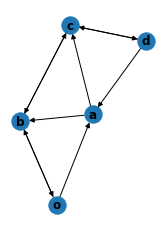

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['o', 'a','b','c','d'])
G.add_edges_from([('o','b'),('b','o'),('o','a'),('a','b'),('a','c'),('b','c'),('c','b'),('c','d'),('d','c'),('d','a')])

plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')


We have simulate the CTMC starting from node 'a' by using a unique "global " Poisson Clock with rate : $$\omega^* = \max_i(\omega_i)$$ where $$\omega_i= \sum_j \Lambda_{ij}$$
So, when I'm at position i and the global clock ticks I can jump to a neighbor j  with probability $$Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$$  or I can stay in the same node (no transition) with probability $$Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$$




In [ ]:
Lambda=[[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,1/3,0,2/3],[0,1/3,0,1/3,0]]
Lambda=np.array(Lambda)
w=np.sum(Lambda,axis=1)
w_star=np.max(w)
print(w_star)
Q=Lambda/w_star
Q=Q+np.diag(np.ones(len(w))-np.sum(Q,axis=1))

values,vectors=np.linalg.eig(Q.T)
index=np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar=pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)
print(w)


1.0
pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
[0.6        1.         1.         1.         0.66666667]


$\bar{\pi}$ represent in a infinite time perspective the time a particle spends in a particular node. The above solution is the one exactly calculated by solving differential equation in (1). Thanks to this values we can have a consideration about the MC structure:
 A particle will spend more time in nodes 'b','c','d' , beacuse are collected with a higher values of $\bar{\pi}$.
 This was espected because of the higher in-degree of this nodes. 

For the simulation task we opt, as said before, for a global wide Poisson cloack and we set as stop condition a finite number of steps. Thanks to the simulation we can get an empirical estimation of $\bar{\pi}$. 

Estimate of pi_bar: [0.2469472  0.14400702 0.22558156 0.22522118 0.15824303]
Avarage error: 0.02724812492101657


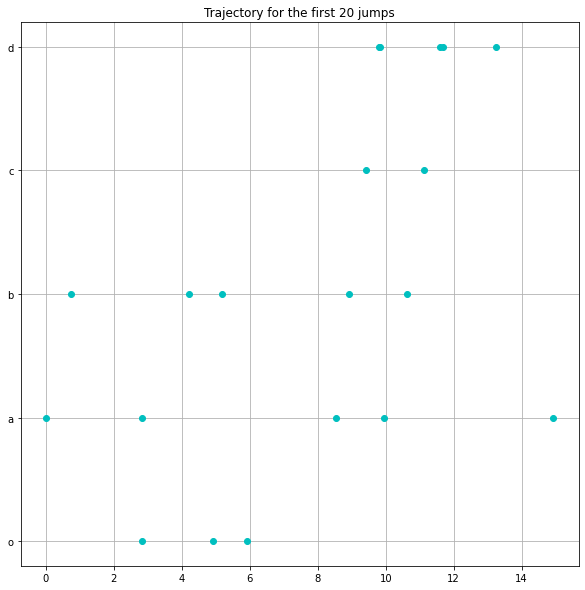

In [ ]:
# 1st approach: global clock with rate w_star and matrix Q

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 1-->node a
pos[0] = 1
# transition_times will store the time instants at which
#transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution 
#in the formula for t_next we use w_star, the rate of the
# "global" Poisson clock
t_next = -np.log(np.random.rand())/w_star


Q_cum = np.cumsum(Q, axis=1)

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of Q corresponding to the current state.
    # to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution Q[pos[i-1],:], we extract a random number in [0,1] and compare it with 
    # the cumulative sums Q_cum[pos[i-1]]. You then pick the first (smallest) state for which
    # the cumulative sum is grater than the random number.
    pos[i] = np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    t_next = -np.log(np.random.rand())/w_star

import matplotlib.pyplot as plt

# plot the trajectory for the first 20 jumps
nodes_for_plot = ['o','a','b','c','d']
plt.figure(figsize=(10,10))
plt.grid(True)
plt.yticks(range(len(nodes_for_plot)), nodes_for_plot, size='medium',)
plt.xticks(np.arange(0,20 , step=2))
plt.plot(transition_times[0:20], pos[0:20], 'co')
plt.title('Trajectory for the first 20 jumps')


# Estimate pi

pi_estimate = np.zeros(5)
# We have the time instants of all transitions, we now compute time intervals.
# Here we set n=1 to compute first difference, which is given by 
# intervals[i] = transition_times[i+1] - transition_times[i].
# We also provide a value to  append to transition_times prior to performing the difference
# so that we can compute also the last interval: 
# transition_times[-1] + t_next is the end of the time horizon.
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)

# for each state in the state space
for state in range(5):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the
    # time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)
print("Avarage error:",np.mean(abs(pi_bar-pi_estimate)))


Because the graph G is strongly connected we can compute the the avarage time it takes a particle that starts in node 'a' to return to node 'a' as:
$$ \mathbb{E}_a[T^+_a]=\frac{1}{\omega_a \bar{\pi_a}}$$
We can compare the result of the simulation with the theoretical ones using the two results of $\bar{\pi}$

In [ ]:
#using pi calculated with the simulation
expected_time=1/(w[1]*pi_estimate[1])
print(expected_time)


7.404307080799304


In [ ]:
#using pi calculated solving the differential equation in (1)
expected_time_pi=1/(w[1]*pi_bar[1])
print(expected_time_pi)
print(w[1])
print(1/pi_bar[1])

6.750000000000007
1.0
6.750000000000007


As we can see the two value are similar.
By increasing the number of iterations used for the simulation the two values become more and more closed.

We can also simulate the random walk on the network using local cloack on each nodes with rate $\omega_i$ and local clock on each node. Where $\omega_i= \sum_j \Lambda_{ij}$.
In this case when you are in node i and the clock of node i ticks you will jump to a neighbor j  with probability  $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$


Estimate of pi_bar: [0.19234464 0.16089488 0.23526737 0.19655721 0.21493591]


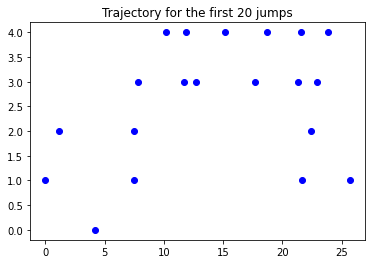

In [ ]:
# 2nd approach: local clocks with rates w_i and matrix P

# contruct the P matrix and clocl rates w
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 1
pos[0] = 1
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution
# NOTE: in the formula for t_next we use the rate of the clock of 
# the current state, in this case w[1].
t_next = -np.log(np.random.rand())/w[1]

# Compute the cumulative sums of the rows of P
P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of P corresponding to the current state.
    pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w[pos[i]]

import matplotlib.pyplot as plt

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(5)

intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
for node in range(5):
    visits = np.argwhere(pos == node)
    pi_estimate[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
print("Estimate of pi_bar:", pi_estimate)

Also in this case we can estimate  the avarage time it takes a particle that starts in node a to return to node a:
$$ \mathbb{E}_a[T^+_a]=\frac{1}{\omega_1 \bar{\pi_1}}$$
where $\bar{\pi_1}$ is the one we have estimate thanks to the simulation.


In [ ]:
#expected return time calculated hanks to the simulation
expected_time=1/(w[1]*pi_estimate[1])
print(expected_time)

6.215238325654248


In [ ]:
#expected return time calculated solving the differential equation(same as before)
expected_time_pi=1/(w[1]*pi_bar[1])
print(expected_time_pi)

6.750000000000007


Also in thise case the theoretical and the simulated valuer are similar. 

The two different approach are equivalent, and the results still closed.

### Point C-D

In order to calculate the the avarage hitting-time we have to modify the simulation, use a starting node the node 'o' and stop the simulation when the node 'd' is reached.
For this task we opt for the global clock.


In [ ]:
# 1st approach: global clock with rate w_star and matrix Q
def calculate_hitting_time(Q_cum):
  # initial position:node 'o'
  current_pos=np.array(0)
  old_pos=0
  # transition_times will store the time instants at which
  #transitions happen
  transition_times = 0
  # the random time to wait for the next transition
  # is drawn according to its distribution 
  #in the formula for t_next we use w_star, the rate of the
  # "global" Poisson clock
  t_next = -np.log(np.random.rand())/w_star

  while current_pos!=4:
      bin=current_pos
      current_pos = int(np.argwhere(Q_cum[old_pos]> np.random.rand())[0])
      old_pos=bin
      
      # store the time instant of the current transition
      transition_times = transition_times+ t_next
      # compute the waiting time to the next transition
      t_next = -np.log(np.random.rand())/w_star
  return(transition_times)


In [ ]:
Q_cum = np.cumsum(Q, axis=1)
X=[]
for i in range(1000):
  x=calculate_hitting_time(Q_cum)
  X.append(x)


In [ ]:
print(np.mean(X))

10.964145522794748


In [ ]:
# contruct the P matrix and clocl rates w
A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
A = A.toarray()
w_A = np.sum(A, axis=1)
D_A = np.diag(w)
P_A = np.linalg.inv(D) @ Lambda

##Exercise 2
###Continuos Time Random Walk with multiple Particles:Particles Perspective
We decide to simulate by using a global clock with rate equal to the number of particles. In order to find a good estimation for the avarage time it takes a particles to return to node 'a' we decide to evalutae it as the averege time of all the particles. We also repeat the experiment  n_iter times and then calculate the avarege on all the simulations.



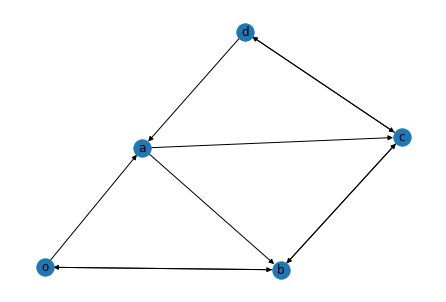

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
Lambda
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
Q = Lambda/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


###Point A

In [ ]:
#Set a system-wide Poisson clock with rate 100:
def particlePerspective(Q_cum):
  rate_nodes = 100
  #count number of particles return to a for the first time
  returned = 0
  #keep trace of the positions of all the particles
  #the key represent the particle id, the value is a list of all positions visited 
  pos = {}

  for i in range(100):
    pos[i] = tuple([1]) #all particles strar in node 'a'

  return_times = np.zeros(100)
  t_tot = 0

  while (returned < 100):
    t_next = -np.log(np.random.rand())/rate_nodes #next move time
    t_tot += t_next
  
    sel_part = np.random.randint( 0, 100) #select a random particle
    x = np.random.rand()
    next_node = np.argwhere(Q_cum[ pos[sel_part][-1] ] > np.random.rand())[0][-1]

    pos[sel_part] = pos[sel_part] , next_node
    #print('particella =', sel_part, 'next_node =', next_node)
    if( return_times[sel_part] == 0 and next_node == 1):#una particella che ancora non era ritornata è tornata
      return_times[sel_part] = t_tot
      returned += 1
      print('returned =', returned, 'particles =', sel_part, 'time =', t_tot)
  print('ciao')
  return return_times


In [ ]:
n_iter = 1000
l= []
for iter in range(n_iter):
  l.append( particlePerspective(Q_cum) )

We calculate the avarage time it takes each particles to leave node 'a' and return to node 'a' 

In [ ]:
avg_each_part = np.mean(l, axis = 0)
print(avg_each_part)

[6.81965518 6.71396738 6.71949485 6.84291735 6.86675198 6.54606076
 6.91984666 6.77484964 6.66062839 7.15355503 7.05537583 6.54436611
 6.94040631 6.67212315 6.69000187 6.77342917 6.77755139 6.80175062
 6.72023404 6.94990264 6.57003662 6.75773324 6.71113759 6.81770571
 6.72281757 6.28596158 6.83915253 6.78545371 6.60720266 6.53924148
 6.85787033 6.82181797 6.90966086 6.83601639 6.82779728 6.47886881
 6.57451764 6.58799309 6.81588779 6.73506269 6.60647473 7.06875739
 6.79614223 6.50167912 6.97524355 6.57761476 6.47796901 7.0945475
 6.57082185 6.74573881 6.77601752 6.84119221 6.62600616 6.83142327
 6.67273699 6.47724255 6.72247983 6.81192122 6.98999796 6.50693324
 6.50539187 6.82077058 6.65043413 6.84329102 7.05070926 6.4364851
 7.03112343 6.89236723 6.70685157 6.54217192 7.03917179 6.76895328
 6.85067641 6.94790073 6.70000425 7.0393095  6.58985545 6.52133571
 6.81514521 6.68311491 7.04255249 6.65806305 6.78900546 6.77569043
 7.01214752 6.87636038 6.69610755 6.92650783 6.74281342 6.666066

As we can see the avarage time (average is intended as the average on different simulations) is similar with the one get in simulation of exercise one: that is 6.88 units of time. 


In [ ]:
tot = 0
for t in l:
  tot += np.min(t)

tot/len(l)

0.6821761453573962

Finally we have compute the mean time among all particles needed to leave node 'a' and return in it. 
In this case the value tends to the theoretical return returned time. 

In [ ]:
tot = 0
for t in l:
  tot += np.mean(t)

tot/len(l)

6.7601544504957

###Point B
In order to simulate the random walk from a node perspective we opt for a global-wide Possion clock.

In [ ]:
Lambda
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
Q = Lambda/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [ ]:
def nodePerspective(Q_cum):
  node_positions = [100, 0, 0, 0, 0] #initial configuraion: all the 100 particles are in node 'o'
  num_iters = 0 #count the number of iteration necessari to reach 60 units of time
  times = 0 #initialize time to 0
  iterations=[] #store the different configuration (partcles per nodes) at each iteration
  rate_nodes = 100 #rate for he gloabl poisson clock 
  while times<60:
      t_next = -np.log(np.random.rand())/rate_nodes #next move time
      num_iters+=1 
      times=times+t_next 
      current_node = np.random.choice(5, 1, p= (np.array(node_positions) /100 ))[0] #choose a random node
      #The node is choosen with probability proportional to the number of particles
      # to extract a value pos[i] in (0,...,num_states-1) according to the discrete
      # distribution Q[pos[i-1],:], we extract a random number in [0,1] and compare it with 
      # the cumulative sums Q_cum[pos[i-1]]. You then pick the first (smallest) state for which
      # the cumulative sum is grater than the random number.
      next_node = int(np.argwhere(Q_cum[ current_node ] > np.random.rand())[0]) 
    
     
      node_positions[current_node] -=1 #move the particles 
      node_positions[next_node] +=1 #to the selected node
      iterations = np.append( iterations, node_positions, axis = 0)# store the result

  iterations = np.reshape( iterations, [num_iters,5])
  
  return iterations,num_iters

In [ ]:
x,num_iters= nodePerspective(Q_cum)


In the following graph we have plot differentent number of particles in each node during the simulation

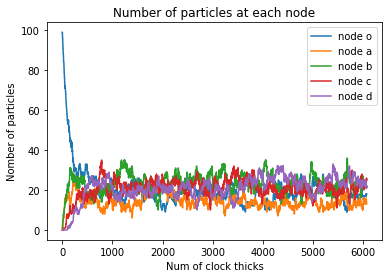

In [ ]:
X=x.T
label=['node o','node a','node b','node c','node d']
for i in range (5):
  plt.plot(range(0,num_iters),X[i][:], label=label[i])

plt.title("Number of particles at each node")
plt.xlabel("Num of clock thicks")
plt.ylabel("Nomber of particles")
plt.legend()
plt.show()

We can compute the mean number of particles for each nodes as:


In [ ]:
mean_particles=np.mean(X,axis=1)
compare=mean_particles/100
print('Mean number of particles at each node is :', mean_particles)
print('if we divide by 100, the rate of the global clock  this number we get the pi_bar estimated in exercise one:\n',compare)

Mean number of particles at each node is : [20.76165376 14.43073629 23.34178883 20.65689343 20.80892769]
if we divide by 100, the rate of the global clock  this number we get the pi_bar estimated in exercise one:
 [0.20761654 0.14430736 0.23341789 0.20656893 0.20808928]


## Exercise 3

In [ ]:
lambda_open = [[0, 1, 0, 0, 0, 0], 
               [0, 0, 2/3, 1/3, 0, 0], 
               [0, 0, 0, 1/4, 1/4, 2/4],
               [0, 0, 0, 0, 1, 0], 
               [0, 0, 0, 0, 0, 1], 
               [0, 0, 0, 0, 0, 1]
              ]

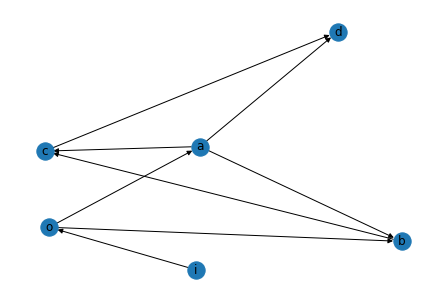

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['i', 'o','a','b','c', 'd'])
G.add_edges_from( [ ('i', 'o'), ('o','a'), ('o','b'),('a','b'),('a','c'), ('a','d'), ('b','c'), ('c','d'), ('d','d')])
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True)

### Point A

In [ ]:
lambda_open

[[0, 1, 0, 0, 0, 0],
 [0, 0, 0.6666666666666666, 0.3333333333333333, 0, 0],
 [0, 0, 0, 0.25, 0.25, 0.5],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1]]

In [ ]:
r1 = 1 #rate ingresso particelle
n_part_tot = 0
t_tot = 0
w = np.sum(lambda_open, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ lambda_open
P_cum = np.cumsum(P, axis=1)

transitions = [100000,0,0,0,0,0] #at each iteration, store the number of particles in each node
stored_transitions = {}
iter = 0
pos = [0]

while t_tot < 60:

  t = [0]*6
  for i in range(6):
    if(i == 0):
      t[i] = -np.log(np.random.rand())/10
    else:
      t[i] = -np.log(np.random.rand())/(transitions[i] + .0000001)
  print('t = ', t)
  t_next = np.min(t) 
  current_node = t.index(t_next)
  
  pos[iter] = current_node

  #print('contatore iterazione =',iter)
  #print('posizione corrent =', pos[iter], 'particelle nel nodo =', transitions[pos[iter]])

  if current_node == 0:
    n_part_tot += 1
    
  elif current_node == 5: #node d
    n_part_tot -= 1
    transitions[5] -= 1

  next_node = int(np.argwhere(P_cum[current_node] > np.random.rand())[0])
  #print('next_node =', next_node)
  t_tot += t_next
  #print('t_next =', t_next)
  print('t_tot =', t_tot)
  if current_node != 5:
    transitions[current_node] -= 1
    transitions[next_node] += 1

  print('distribuzione delle particelle =', transitions)
  iter += 1
  pos.append( next_node )
  stored_transitions[t_tot] = transitions[1:]
  print('\n\n\n\n')


Output streaming troncato alle ultime 5000 righe.
t =  [0.23413295056676425, 0.011464497786186186, 0.2141086747872063, 0.3377749615985517, 0.012634792961486542, 0.2848181727860133]
t_tot = 48.42051250653669
distribuzione delle particelle = [99526, 10, 9, 5, 12, 10]





t =  [0.36304847085678416, 0.04298501003595112, 0.05218967879949232, 0.005210834343615613, 0.005490775475746746, 0.00182469200983811]
t_tot = 48.42233719854653
distribuzione delle particelle = [99526, 10, 9, 5, 12, 9]





t =  [0.11584965033432493, 0.03606917884190074, 0.005112344181941513, 0.13755852201894414, 0.03134037198421021, 0.3099747055791535]
t_tot = 48.42744954272847
distribuzione delle particelle = [99526, 10, 8, 5, 13, 9]





t =  [0.006275029237382613, 0.11691939786279805, 0.15835099738110217, 0.037022570180598555, 0.10692657365654815, 0.04326329825268592]
t_tot = 48.43372457196585
distribuzione delle particelle = [99525, 11, 8, 5, 13, 9]





t =  [0.018489207916077922, 0.07408760441393952, 0.50794018826

In [ ]:
x = list(stored_transitions.values())
x = np.array(x).T

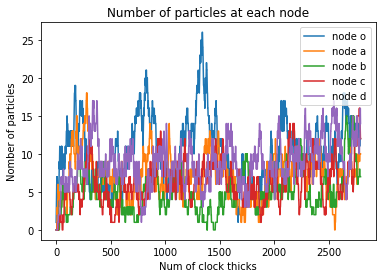

In [ ]:
label=['node o','node a','node b','node c','node d']
for i in range (5):
  plt.plot(range(0,iter), x[i][:], label=label[i])

plt.title("Number of particles at each node")
plt.xlabel("Num of clock thicks")
plt.ylabel("Nomber of particles")
plt.legend()
plt.show()

### Point B

In [ ]:
rate = 10#rate ingresso particelle
n_part_tot = 0
t_tot = 0
w = np.sum(lambda_open, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ lambda_open
P_cum = np.cumsum(P, axis=1)

transitions = [100000,0,0,0,0,0] #at each iteration, store the number of particles in each node
stored_transitions = {}
iter = 0
pos = [0]
cnt0 = 0
cnt1 = 0
while t_tot < 60:
  t = [1000]*6
  for i in range(6):
    if(i == 0):
      t[i] = -np.log(np.random.rand())/rate
    elif transitions[i] != 0:
      t[i] = -np.log(np.random.rand())/1
  print('t = ', t)
  t_next = np.min(t) 
  current_node = t.index(t_next)
  
  pos[iter] = current_node

  #print('contatore iterazione =',iter)
  #print('posizione corrent =', pos[iter], 'particelle nel nodo =', transitions[pos[iter]])

  

  if current_node == 0:
    n_part_tot += 1
    cnt0 +=1
    
  elif current_node == 5: #node d
    n_part_tot -= 1
    transitions[5] -= 1
    cnt1 +=1

  
  next_node = int(np.argwhere(P_cum[current_node] > np.random.rand())[0])
  #print('next_node =', next_node)
  t_tot += t_next
  #print('t_next =', t_next)
  print('t_tot =', t_tot)
  if current_node != 5:
    transitions[current_node] -= 1
    transitions[next_node] += 1

  print('distribuzione delle particelle =', transitions)
  iter += 1
  pos.append( next_node )
  stored_transitions[t_tot] = transitions[1:]
  print('\n\n\n\n')

Output streaming troncato alle ultime 5000 righe.
t =  [0.16937758355391797, 0.3042741031704702, 1.2467970410592197, 0.7856828909416634, 1000, 0.2880299465396526]
t_tot = 15.513646051234062
distribuzione delle particelle = [99848, 137, 2, 3, 0, 1]





t =  [0.012284511639080245, 0.6836258739625661, 0.6266295169635794, 1.9537064704155525, 1000, 0.8296080697340626]
t_tot = 15.525930562873143
distribuzione delle particelle = [99847, 138, 2, 3, 0, 1]





t =  [0.04670307976160422, 0.07815129035575852, 1.1034933705399195, 0.2928679913420707, 1000, 0.2504579639640003]
t_tot = 15.572633642634747
distribuzione delle particelle = [99846, 139, 2, 3, 0, 1]





t =  [0.1701365905457982, 1.045889746165027, 1.748595607089093, 0.5958538008227063, 1000, 2.30842026992262]
t_tot = 15.742770233180545
distribuzione delle particelle = [99845, 140, 2, 3, 0, 1]





t =  [0.11423436227506949, 2.0293596721896026, 1.0906177954531173, 0.9970749420128308, 1000, 0.8880072526424531]
t_tot = 15.857004595455615
d

In [ ]:
x = list(stored_transitions.values())
x = np.array(x).T

In [ ]:
x

array([[  1,   0,   1, ..., 507, 508, 509],
       [  0,   0,   0, ...,   1,   1,   1],
       [  0,   1,   1, ...,   2,   2,   2],
       [  0,   0,   0, ...,   1,   1,   1],
       [  0,   0,   0, ...,   4,   4,   4]])

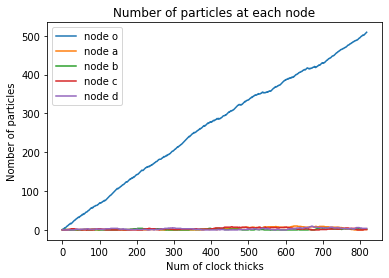

In [ ]:
label=['node o','node a','node b','node c','node d']
for i in range (5):
  plt.plot(range(0,iter), x[i][:], label=label[i])

plt.title("Number of particles at each node")
plt.xlabel("Num of clock thicks")
plt.ylabel("Nomber of particles")
plt.legend()
plt.show()